This notebook is for control clusteirng analysis of matched cells in the familiar sessions in visual behavior dataset.
Comparing clusters in just familiar sessions and familia+novel+novel+ should give us more information about representaitonal drift

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})

In [138]:
import visual_behavior.data_access.utilities as utilities
from visual_behavior.data_access import loading as loading
import visual_behavior.dimensionality_reduction.clustering as vba_clust

In [22]:
import visual_behavior_glm.GLM_params as glm_params
import visual_behavior_glm.GLM_analysis_tools as gat
import visual_behavior_glm.GLM_visualization_tools as gvt
import visual_behavior_glm.GLM_fit_dev as glm_fit

In [8]:
import visual_behavior.visualization.utils as utils
from visual_behavior.dimensionality_reduction.clustering import plotting
from visual_behavior.dimensionality_reduction.clustering import processing

In [175]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering as ac

In [9]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [10]:
glm_version = '24_events_all_L2_optimize_by_session'
model_output_type = 'adj_fraction_change_from_full'

base_dir = r'\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_plots\figure_4'
base_dir = os.path.join(base_dir, glm_version)
if not os.path.exists(base_dir):
    os.mkdir(base_dir)
    
folder = '220922_familiar_control'
save_dir = os.path.join(base_dir, folder)
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
    
folder = '220226_across_session_norm'
load_from_dir = os.path.join(base_dir, folder)
if not os.path.exists(load_from_dir):
    os.mkdir(load_from_dir)

In [19]:
run_params, results, results_pivoted, weights_df = glm_fit.get_analysis_dfs(glm_version)

Interpolating kernels: 100%|███████████████████████████████████████████████████████████| 16/16 [00:56<00:00,  3.56s/it]


Computing average kernels


In [21]:
familiar_only = results_pivoted[results_pivoted.experience_level == 'Familiar']

In [30]:
familiar_only.session_type.unique()

array(['OPHYS_1_images_B', 'OPHYS_2_images_B_passive', 'OPHYS_3_images_B',
       'OPHYS_1_images_A', 'OPHYS_3_images_A', 'OPHYS_2_images_A_passive'],
      dtype=object)

In [35]:
active_only = familiar_only[familiar_only.session_type.isin(['OPHYS_1_images_B','OPHYS_3_images_B','OPHYS_1_images_A','OPHYS_3_images_A'])]

In [125]:
tmp = active_only.groupby('cell_specimen_id').count()[['session_type']]
matched_cell_ids = tmp[tmp['session_type']>=3].index.values
len(matched_cell_ids)

1450

In [62]:
selected_sessions = active_only[active_only.cell_specimen_id.isin(matched_cell_ids)]

In [124]:
dropout_features = ['all-images', 'omissions', 'behavioral', 'task']

In [86]:
selected_sessions = selected_sessions.sort_values('date_of_acquisition')

In [119]:
### rename session numbers to be sequential
for cid in matched_cell_ids:
    tmp = selected_sessions[selected_sessions.cell_specimen_id == cid]
    count = 1
    for index in tmp.index.values:
        selected_sessions.at[index, 'session_number'] = count
        count =count+1
    

In [123]:
feature_matrix = selected_sessions.groupby(['cell_specimen_id', 'session_number']).sum()[dropout_features].unstack()

In [131]:
feature_matrix = feature_matrix.dropna(axis=1)

In [132]:
feature_matrix

all-images                     omissions                      \
session_number            1         2         3         1         2         3   
cell_specimen_id                                                                
1086491395        -0.744411 -0.372261 -0.980643  0.000000  0.000000  0.000000   
1086491508         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1086491716         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1086491863         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1086492072         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
...                     ...       ...       ...       ...       ...       ...   
1120095573        -0.831220 -0.819324 -0.764064 -0.032262 -0.029959  0.000000   
1120095819        -0.780581 -0.919207 -0.842481  0.000000  0.000000  0.000000   
1120095948        -0.760145 -0.764788 -0.676987  0.000000 -0.103167  0.000000   
1120096160        -0.851505 -0.841903 -0.738572 -0.086735 -0.051908 -0.073044   
1120096389        -0.368728 -0.552267 -0.588819 -0.117173 -0.147310 -0.131869   

                 behavioral                          task                      
session_number            1         2         3         1         2         3  
cell_specimen_id                                                               
1086491395        -0.213908 -0.614764 -0.092488  0.000000  0.000000  0.000000  
1086491508         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
1086491716         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
1086491863         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
1086492072         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
...                     ...       ...       ...       ...       ...       ...  
1120095573        -0.001734 -0.017151 -0.002389 -0.151166 -0.128497 -0.125826  
1120095819         0.000000  0.000000 -0.003087 -0.237847  0.000000 -0.192262  
1120095948         0.000000 -0.012695  0.000000 -0.031747 -0.011487 -0.064083  
1120096160         0.000000 -0.041561  0.000000 -0.083353 -0.033368 -0.218811  
1120096389        -0.018986 -0.025121 -0.040870 -0.456873 -0.330928 -0.260504  

[1450 rows x 12 columns]

In [136]:
cre_lines = np.sort(selected_sessions['cre_line'].unique())
cre_line_dfs = {}
for cre_line in cre_lines:
    cids = selected_sessions[selected_sessions['cre_line']==cre_line]['cell_specimen_id'].values
    print(len(cids))
    df_cre = feature_matrix.loc[cids].copy()
    cre_line_dfs[cre_line] = df_cre

3672
460
478


Optimal number of clusters [   2    1    4    6    5    3    9   10   11   13    8    7   15   16
   12   14   21 3669 3658   19   20 3666   22   34   29]
Optimal number of clusters [  1   2   3   4   7   6   5 456   9   8 458  11  17  14  10  13  22  15
  20 453  16 433 454  21  23]
Optimal number of clusters [ 1  3  4  5 11  6  9  7  2 21 15 12 18 13 14  8 20 10 28 16 19 24 29 17
 25]


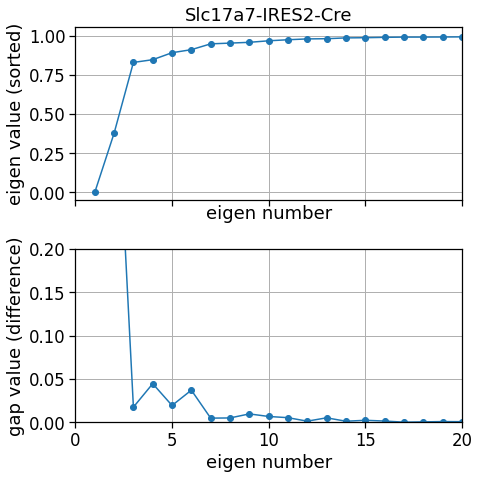

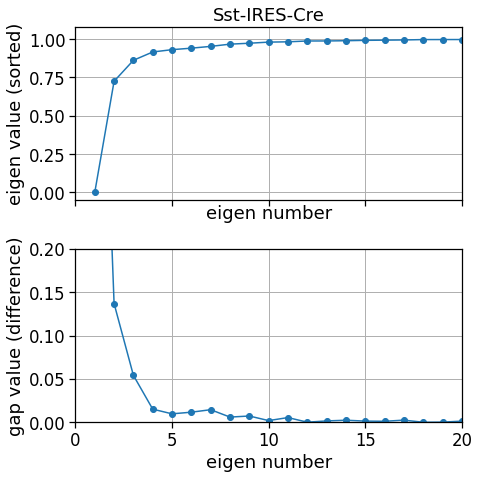

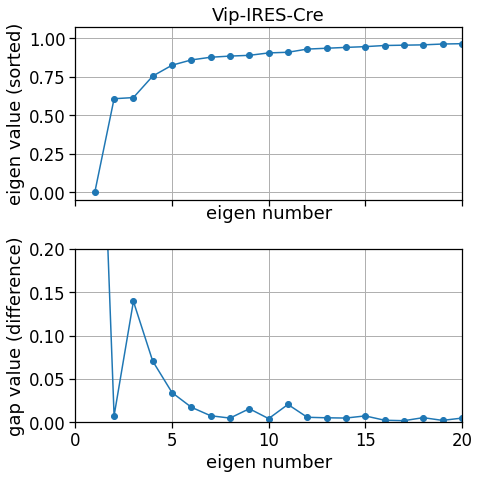

In [168]:
eigenGap_df = {}
for i, cre_line in enumerate(cre_lines):
    X = cre_line_dfs[cre_line].values
    sc = SpectralClustering()
    sc.fit(X)
    A = sc.affinity_matrix_
    
    eigenvalues, eigenvectors, nb_clusters = vba_clust.get_eigenDecomposition(A)
    
    fig, ax = plt.subplots(2,1, figsize = (7,7), sharex=True)
    ax[0].plot(np.arange(1,len(eigenvalues)+1), eigenvalues, '-o')
    ax[0].grid()
    ax[0].set_title(cre_line)
    ax[0].set_ylabel('eigen value (sorted)')
    ax[0].set_xlabel('eigen number')
    ax[0].set_xlim([0, 20])
    #ax[0].set_xticks([np.arange(2,20,step = 2)])
    
    ax[1].plot(np.arange(1,len(eigenvalues)), np.diff(eigenvalues), '-o')
    ax[1].set_ylabel('gap value (difference)')
    ax[1].set_xlabel('eigen number')
    ax[1].set_xlim([0, 20])
    ax[1].set_ylim([0, 0.20])
    ax[1].grid()
    plt.tight_layout()
    fig.savefig(os.path.join(save_dir, f'eigenGap_{cre_line}.png'))
    eigenGap_df[cre_line] = [ eigenvalues, eigenvectors, nb_clusters]
    print(f'Optimal number of clusters {nb_clusters}')
        
    

In [ ]:
distance_metrics = ['euclidean']
shuffle_types=['all']

gap_filename = os.path.join(save_dir, 'gap_scores_{}_{}_nb20_unshuffled_to_{}.pkl'.format(metric, glm_version, shuffle_type))
if os.path.exists(gap_filename):
    print('file exists...')
else:
    gap_df = {}
    for i, cre_line in enumerate(cre_lines):
        X = cre_line_dfs[cre_line]
        sc = SpectralClustering()
        shuffled_df = vba_clust.shuffle_dropout_score(cre_line_dfs[cre_line], shuffle_type=shuffle_type)
        reference = shuffled_df.values
        gap_statistics = vba_clust.compute_gap(sc, X, k_max = 25)
        gap_df[cre_line]= gap_statistics
    vba_clust.save_clustering_results(gap_df, gap_filename)

In [ ]:

gap_filename = os.path.join(save_dir, 'gap_scores_{}_{}_nb20_unshuffled_to_{}.pkl'.format(metric, glm_filename[:-3], shuffle_type))        

if os.path.exists(gap_filename):
    print('loading file...')
with open(gap_filename, 'rb') as f:
    gap_df  = pkl.load(f)
    f.close()
    print('done.')

for cre_line in cre_lines:
    fig, ax = plt.subplots(1,2, figsize = (10,3))
    x = len(gap_df[cre_line][0])
    ax[0].plot(np.arange(2,x+2), gap_df[cre_line][0], 'o-')
    ax[0].set_ylabel('gap value')
    ax[0].grid()
    ax[1].plot(np.arange(2,x+2),gap_df[cre_line][1], 'o-')
    ax[1].plot(np.arange(2,x+2),gap_df[cre_line][2], 'o-')
    ax[1].legend(['reference inertia', 'ondata intertia'])
    ax[1].grid()
    plt.suptitle(cre_line + ' ' + metric + ' ' + shuffle_type)
    fig.savefig(os.path.join(fig_path, 'Gap_nb20_{}_{}_unshuffled_to_{}.png'.format(cre_line, metric, shuffle_type)))


In [196]:
filename = os.path.join(save_dir, 'coClustering_matrix.pkl')
if os.path.exists(filename):
    print('loading file...')
    with open(filename, 'rb') as f:
        coclustering_matrices  = pkl.load(f)
        f.close()
        print('done.')
else:
    n_clusters_cre = [10,5,10] # these n clusters are based on old sil plots
    coclustering_matrices = {}
    for i, cre_line in enumerate(cre_lines):
        X = cre_line_dfs[cre_line].values
        m = vba_clust.get_coClust_matrix(X=X,n_clusters=n_clusters_cre[i], nboot=np.arange(50))
        coclustering_matrices[cre_line]=m
    vba_clust.save_clustering_results(coclustering_matrices, filename)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.36it/s]


In [197]:
labels_cre={}
for i,cre_line in enumerate(cre_lines):
    X = coclustering_matrices[cre_line]
    cluster = ac(n_clusters=n_clusters_cre[i], affinity='euclidean', linkage='average')
    labels_cre[cre_line] = cluster.fit_predict(X)

C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


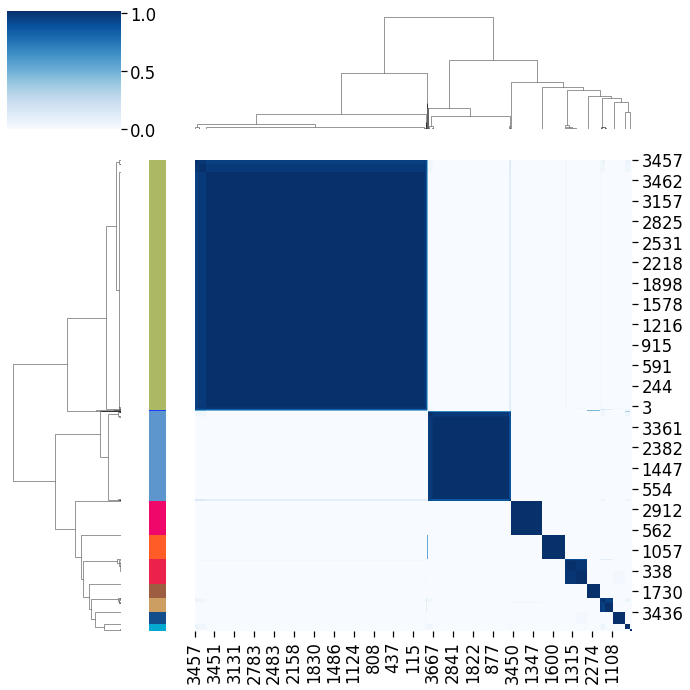

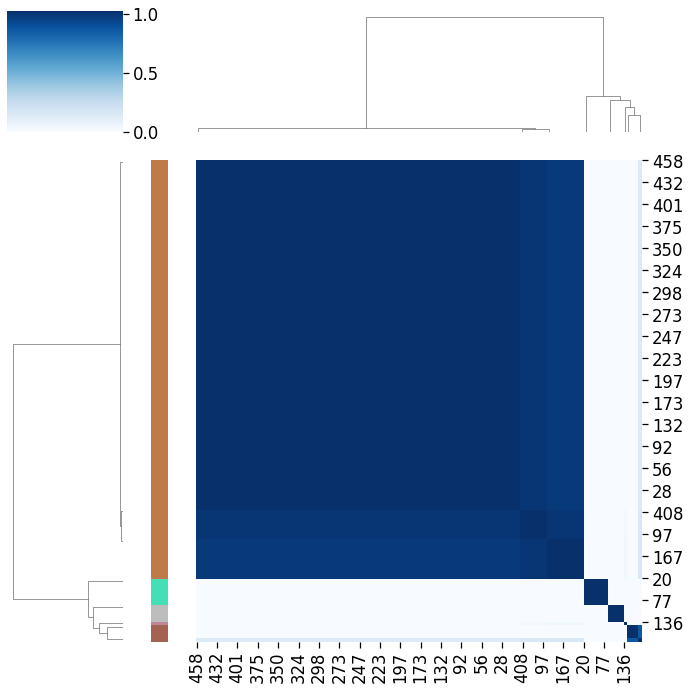

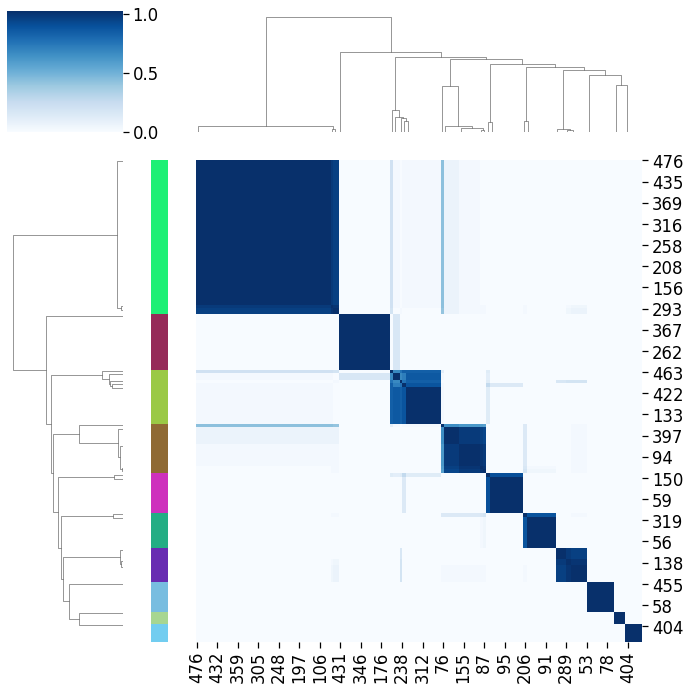

In [198]:
for i, cre_line in enumerate(cre_lines):
    labels = labels_cre[cre_line] 
    row_colors = vba_clust.get_cluster_colors(labels)
    fig = sns.clustermap(coclustering_matrices[cre_line], cmap = 'Blues', row_colors = row_colors)
    plt.tight_layout()
    fig.savefig(os.path.join(save_dir, 'Clustermap_{}_{}_nc{}.png'.format(cre_line, 
                                                                    glm_version,
                                                                    n_clusters_cre[i])))
    

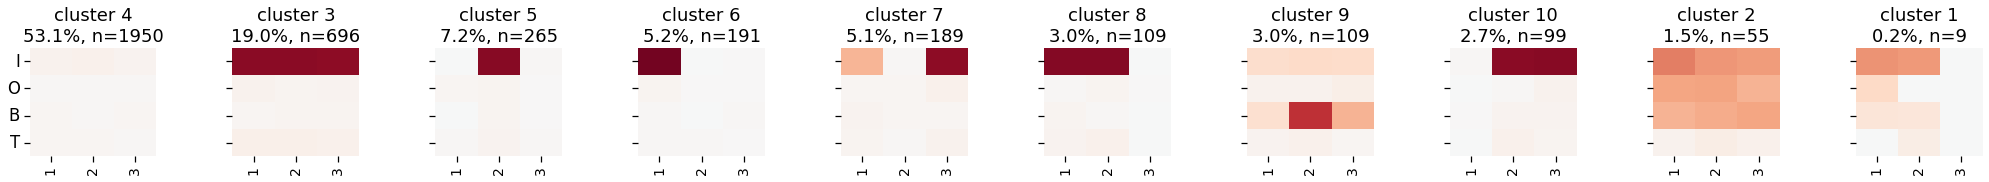

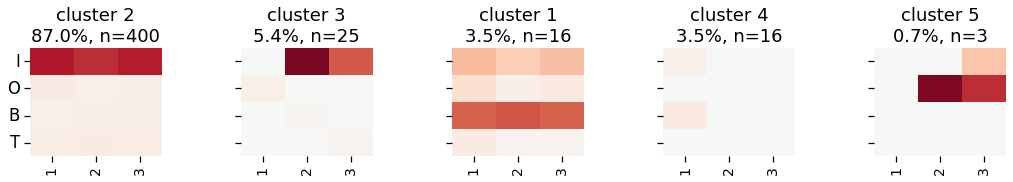

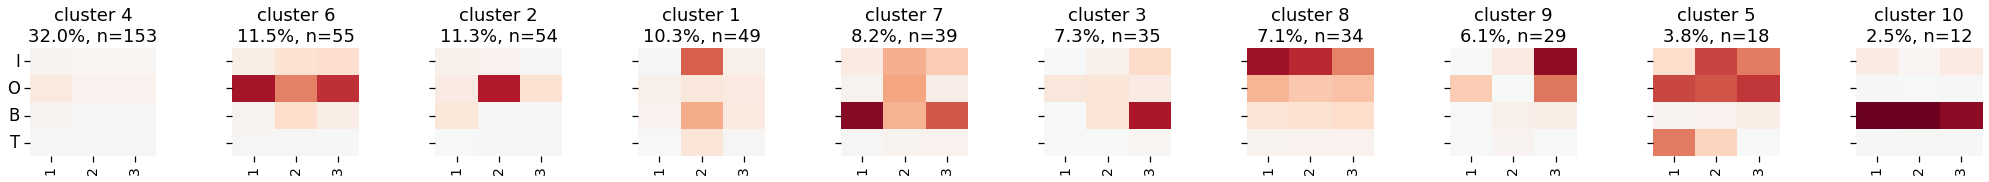

In [200]:
# plotclusters
sort_order = {}
for cre_line in cre_lines:
    feature_matrix = cre_line_dfs[cre_line]
    labels = labels_cre[cre_line] 
    cluster_df = pd.DataFrame(index = feature_matrix.index.values, columns = ['cluster_id', 'cre_line'], 
                              data = np.transpose([labels+1, [cre_line]* len(labels)]))
    #cluster_df = original_cluster_labels[original_cluster_labels.cre_line == cre_line].set_index('cell_specimen_id')
    sort_order[cre_line] = vba_clust.get_sorted_cluster_ids(cluster_df)
    vba_clust.plot_clusters_row(cluster_df, feature_matrix, cre_line,
                               sort_order=sort_order, save_dir=save_dir, folder='', suffix='_familiar_only',
                                 abbreviate_experience=False)
